<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/Transfer%20Learning%3A%20%20VGG16%20%26%20dogs%20vs%20cats%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Transfer Learning:  VGG16 & dogs vs cats classification </center></h1>

## Step 0: Import libraries

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, adam, Adadelta
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input


from keras.applications.imagenet_utils import decode_predictions

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random
% matplotlib inline
import matplotlib.pyplot as plt

# Confusion matrix result
from sklearn.metrics import classification_report, confusion_matrix

# visualizating of confusion matrix
import seaborn as sn
import pandas as pd

# upload new images
import urllib.request
import os
import cv2
import glob

Using TensorFlow backend.


## Step 1: Load data from Kaggle

In [0]:
def load_data_from_kaggle():
  os.environ['KAGGLE_USERNAME'] = "maggie" # username from the json file 
  os.environ['KAGGLE_KEY'] = "7adfc6c4e6c5eec087031fbb7397aee" # key from the json file (This key is incorrect5)
  
  !pip install -q kaggle
  !kaggle datasets list -s dogs-vs-cats  # It will list the 20 datasets including "dogs-vs-cats" from kaggle
  !kaggle datasets download -d biaiscience/dogs-vs-cats -p /content/
  !unzip -q /content/dogs-vs-cats.zip -d /content/dogs-vs-cats/
  !unzip -q /content/dogs-vs-cats/train.zip -d /content/dogs-vs-cats/
  !unzip -q /content/dogs-vs-cats/test.zip -d /content/dogs-vs-cats/
  
  # splits pictures into cats and dogs files for train dataset
  os.mkdir("/content/dogs-vs-cats/train/cats")
  os.mkdir("/content/dogs-vs-cats/train/dogs")

  # create validation file to store validation dataset
  os.mkdir("/content/dogs-vs-cats/validation")

  os.mkdir("/content/dogs-vs-cats/validation/cats")
  os.mkdir("/content/dogs-vs-cats/validation/dogs")

  # create subfile from test to store testing dataset
  os.mkdir("/content/dogs-vs-cats/test/unlabelled")
  
  # move all pictures labelled "cat" to "/cat/s" file and all picture labelled "dog" to "/dogs/" file in training
  pathes = glob.glob('/content/dogs-vs-cats/train/*.jpg')
  for path in pathes:
    head, tail = os.path.split(path)
    if tail[:3] == "cat":
      new_path = head + "/cats/" + tail  
    else:
      new_path = head + "/dogs/" + tail
    os.rename(path, new_path)
    
  # move all pictures from testing file to test subfile "/unlabelled/" for predicting later
  pathes = glob.glob('/content/dogs-vs-cats/test/*.jpg')
  for path in pathes:
    head, tail = os.path.split(path)
    new_path = head + "/unlabelled/" + tail
    os.rename(path, new_path)
    
  # cats in validation data
  cats_pathes = glob.glob('/content/dogs-vs-cats/train/cats/*.jpg') 
  val_cats_idx = random.sample((range(12500)), k = 1250)
  val_cats = [cats_pathes[idx] for idx in val_cats_idx]

  for path in val_cats:
    head, tail = os.path.split(path)  
    new_path = head[:-10] + "validation/cats/" + tail 
    os.rename(path, new_path)  

  # dogs in validation data
  dogs_pathes = glob.glob('/content/dogs-vs-cats/train/dogs/*.jpg') 
  val_dogs_idx = random.sample((range(12500)), k = 1250)
  val_dogs = [dogs_pathes[idx] for idx in val_dogs_idx]

  for path in val_dogs:
    head, tail = os.path.split(path)  
    new_path = head[:-10] + "validation/dogs/" + tail 
    os.rename(path, new_path)  
    
  DATADIR_train = "/content/dogs-vs-cats/train"
  DATADIR_validation = "/content/dogs-vs-cats/validation"
  DATADIR_test = "/content/dogs-vs-cats/test"
  
  # train file
  train_dogs_dir = os.path.join(DATADIR_train, "dogs")
  train_cats_dir = os.path.join(DATADIR_train, "cats")
  train_dog_fnames = os.listdir(train_dogs_dir)
  train_cat_fnames = os.listdir(train_cats_dir)

  print("Images from Training file:")
  print("cats:", train_cat_fnames[:5])
  print("dogs:", train_dog_fnames[:5])
  print('total training cat images :', len(train_cat_fnames))
  print('total training dog images :', len(train_dog_fnames ))
  print()

  # validation file
  validation_dogs_dir = os.path.join(DATADIR_validation, "dogs")
  validation_cats_dir = os.path.join(DATADIR_validation, "cats")
  validation_dog_fnames = os.listdir(validation_dogs_dir)
  validation_cat_fnames = os.listdir(validation_cats_dir)

  print("Images from validation file:")
  print(validation_cat_fnames[:5])
  print(validation_dog_fnames[:5])
  print('total validation cat images :', len(validation_cat_fnames))
  print('total validation dog images :', len(validation_dog_fnames ))
  print()

  # test file
  #pathes_test = glob.glob('/content/dogs-vs-cats/test/*.jpg')
  test_dir = os.path.join(DATADIR_test, "unlabelled")
  test_fnames = os.listdir(test_dir)
  print("Images from test file:")
  print(test_fnames[:5])
  print('total test images :', len(test_fnames))


In [0]:
load_data_from_kaggle()

ref                                                   title                                               size  lastUpdated          downloadCount  
----------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
nafisur/dogs-vs-cats                                  Dogs_vs_cats                                       217MB  2018-04-25 08:01:49           1485  
biaiscience/dogs-vs-cats                              Dogs vs Cats                                       814MB  2017-12-05 14:03:33           1576  
dhirensk/cats-vs-dogs-training8000test2000            Cats vs Dogs Training8000Test2000                  218MB  2018-11-21 09:38:07            121  
kanwalinder/cats-vs-dogs-redux-transfer-features      Cats vs Dogs Redux Transfer Features                 1GB  2018-08-22 00:46:31             68  
prasunroy/natural-images                              Natural Images                                     1

## Step 2: Use image generator to preprocess images

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2, 
    zoom_range = 0.2,    
    horizontal_flip = True)  # augumentation to add noise to data: shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True

val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2, 
    zoom_range = 0.2,    
    horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 100

train_generator = train_datagen.flow_from_directory("/content/dogs-vs-cats/train", class_mode = "binary", target_size = (150, 150), batch_size = batch_size)
validation_generator = val_datagen.flow_from_directory("/content/dogs-vs-cats/validation", class_mode = 'binary', target_size = (150, 150), batch_size = batch_size)
test_generator = test_datagen.flow_from_directory("/content/dogs-vs-cats/test", target_size = (150, 150), batch_size = batch_size, class_mode = None, shuffle = False )

batchX, batchy = train_generator.next()
print("Batch shape = {}, min = {}, max = {}".format(batchX.shape, batchX.min(), batchX.max()))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Batch shape = (100, 150, 150, 3), min = 0.0, max = 1.0


## Step 3: Visualize the training data (~~~)

## Step 4: Import the VGG16 Model to implement transfer learning

The dataset of dogs vs cats is small (814 MB) and similar to the VGG16 dataset. So, we will remove the fully connected layers of the pre-trained network near the end. To implement this, we set 'include_top = False', while loading the ResNet50 model.

#### 4.1 import the VGG16 model

In [0]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
                          

# freeze the weights from ResNet50 Model
for layer in vgg16.layers:   
  layer.trainable = False

vgg16.summary()

W0804 17:20:58.372192 139643376539520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 17:20:58.416874 139643376539520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 17:20:58.425017 139643376539520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 17:20:58.474182 139643376539520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 2s 0us/step


W0804 17:21:01.857450 139643376539520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0804 17:21:01.859088 139643376539520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### 4.2. Get familar with how the original VGG16 look like

In [0]:
vgg16_old = VGG16(weights='imagenet')
vgg16_old.summary()

553467904/553467096 [==============================] - 17s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_p

#### 4.3 Model:  VGG16 model (include_top = False) + Fully connected layer and some other layers


In [0]:
model = Sequential([
    vgg16,
    
    Flatten(),
    Dense(64),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])


filepath="weights.VGG16_transfer_learning.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#model.load_weights("weights.VGG16_transfer_learning.hdf5")

model.summary()


W0804 17:21:24.714944 139643376539520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                131088    
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
__________

In [0]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = "adam", 
              metrics = ['accuracy'])

W0804 17:21:25.039095 139643376539520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0804 17:21:25.068569 139643376539520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### 4.4 Saving weights for future use to save computation

In [0]:
# saving weights
fname = "weights_transfer_vgg16.hdf5"
model.save_weights(fname, overwrite = True)

In [0]:
# loading weights
fname = "weights_transfer_vgg16.hdf5"
model.save_weights(fname)

## Step 5: Fitting/Training the model

In [0]:
steps_per_epoch = train_generator.n//train_generator.batch_size 
validation_steps = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
            train_generator,
            steps_per_epoch = steps_per_epoch,
            validation_data = validation_generator,
            validation_steps = validation_steps,
            epochs=100)

Epoch 1/100
225/225 [==============================] - 192s 852ms/step - loss: 0.4296 - acc: 0.8041 - val_loss: 0.2779 - val_acc: 0.8808
Epoch 2/100
225/225 [==============================] - 181s 804ms/step - loss: 0.2996 - acc: 0.8746 - val_loss: 0.3334 - val_acc: 0.8568
Epoch 3/100
225/225 [==============================] - 179s 797ms/step - loss: 0.2785 - acc: 0.8860 - val_loss: 0.2703 - val_acc: 0.8820
Epoch 4/100
225/225 [==============================] - 178s 791ms/step - loss: 0.2628 - acc: 0.8927 - val_loss: 0.2705 - val_acc: 0.8840
Epoch 5/100
225/225 [==============================] - 179s 795ms/step - loss: 0.2511 - acc: 0.8997 - val_loss: 0.2361 - val_acc: 0.8924
Epoch 6/100
225/225 [==============================] - 179s 797ms/step - loss: 0.2478 - acc: 0.8989 - val_loss: 0.2397 - val_acc: 0.8988
Epoch 7/100
225/225 [==============================] - 179s 798ms/step - loss: 0.2412 - acc: 0.9026 - val_loss: 0.2298 - val_acc: 0.9032
Epoch 8/100
225/225 [====================

In [0]:
#weights.VGG16_transfer_learning.hdf5

## Step 6: Evaluating the model

In [0]:
validation_steps = validation_generator.n//validation_generator.batch_size 

result = model.evaluate_generator(generator = validation_generator, steps = validation_steps)
print("The validation accuracy: {:.4f}".format(result[1]))
print("The validation loss: {:.4f}".format(result[0]))

The validation accuracy: 0.8944
The validation loss: 0.2393


#### 6.1 Analysis of the accuracy & loss for the transferred model

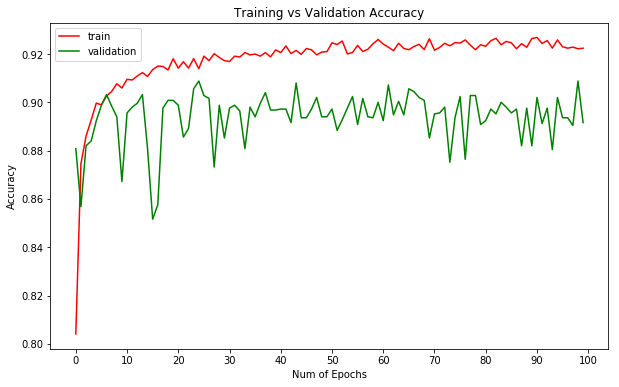

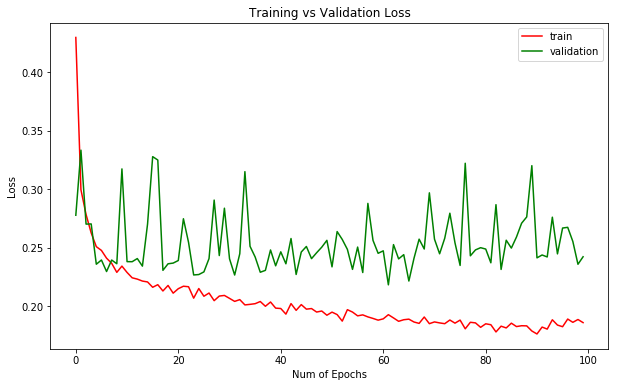

In [0]:
epochs = 100
#plt.figure(0)
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'g')
plt.xticks(np.arange(0, epochs + 1, 10.0))
#plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

#plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
#plt.xticks(np.arange(0, epochs + 1, 10.0))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

## Conclusion

The number of trainable parameters in the transfer model is low as compared to our scratch model. Apart from this, the CNN scratch model took quite a long time to train on GPG, while the transfer model took less than to train the model. We can conclude that the use of transfer learning not only improves the performance of the model but also is computationally efficient.

Next, we can use techniques to further improve the performance of the model:

- implement data augumentation
- fine tuning the optimizer and loss function 
- use L1 and L2 regularization
- use a different pre-trained model 
- fine tune the layers of the pre-trained model


## Useful references
URL_1 = 'https://www.hackerearth.com/practice/machine-learning/transfer-learning/transfer-learning-intro/tutorial/'

URL_2 = "https://www.learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/"

URL_3 = "https://mathematica.stackexchange.com/questions/145281/how-to-finetune-a-large-pretrained-netmodel/145317#145317"

URL_4 = "https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e"